# Борьба с выбросами в очищенных данных

## Импорт библиотек

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import re

## Открытие данных

In [269]:
df = pd.read_csv('../clean_data.csv', sep=';')

In [270]:
df.sample(3)

,number of rooms,area of apartment,number of floors,apartment floor,price,repair,bathroom,terrace,year of construction,elevator,type of house,parking,district,full address,concierge,garbage chute
1603,1,30.0,5,3,1620000.0,косметический,совмещенный,балкон,1962,0.0,блочный,открытая во дворе,р-н Орджоникидзевский,"Пермский край, Пермь, 1-й Дубровский пер., 10",0,0
603,2,56.3,9,8,3600000.0,требует ремонта,раздельный,лоджия,1991,1.0,панельный,открытая во дворе,р-н Мотовилихинский,"Пермский край, Пермь, Уинская ул., 8",0,1
1858,4,87.0,11,6,9999999.0,евро,совмещенный,лоджия,2021,2.0,монолитный,подземная,р-н Индустриальный,"Пермский край, Пермь, ул. Карпинского, 53А",0,0


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number of rooms       1894 non-null   int64  
 1   area of apartment     1894 non-null   float64
 2   number of floors      1894 non-null   int64  
 3   apartment floor       1894 non-null   int64  
 4   price                 1894 non-null   float64
 5   repair                1894 non-null   object 
 6   bathroom              1894 non-null   object 
 7   terrace               1894 non-null   object 
 8   year of construction  1894 non-null   int64  
 9   elevator              1894 non-null   float64
 10  type of house         1894 non-null   object 
 11  parking               1640 non-null   object 
 12  district              1894 non-null   object 
 13  full address          1894 non-null   object 
 14  concierge             1894 non-null   int64  
 15  garbage chute        

## Удаление выбросов в количественных признаках

### Обнаружение признаков с выбросами

In [272]:
numeric_features = []
for column in df.columns:
    if str(df[column].dtype) != "object":
        numeric_features.append(column)
print("Количество признаков: " + str(len(numeric_features)))

Количество признаков: 9


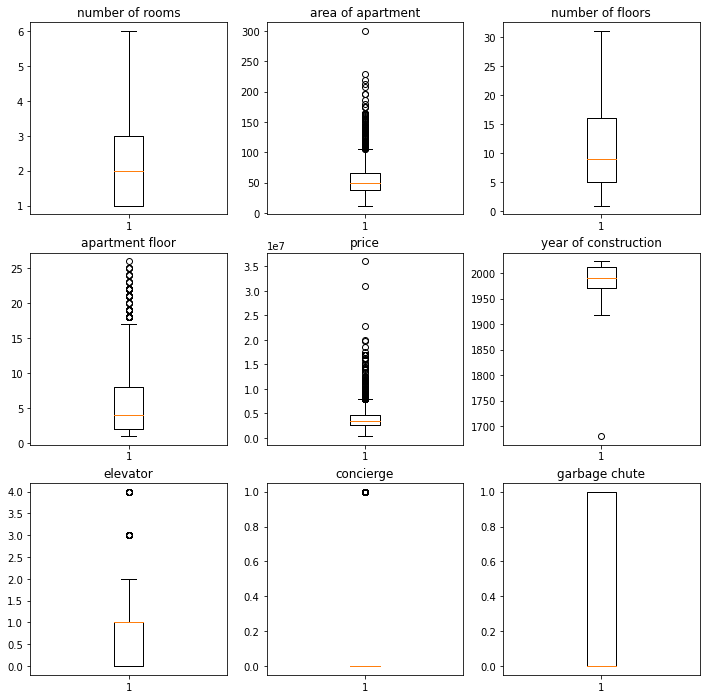

In [273]:
plt.figure(figsize=(12, 12))
for idx, feature in enumerate(numeric_features):
    plt.subplot(3, 3, idx+1)
    plt.boxplot(df[feature])
    plt.title(feature)

Признаки с критическими выбросами:
1. площадь квартиры
2. цена
3. год постройки

Остальные признаки, хотя и содержат выбросы, но порядки, в которых они отличаются от обычных значений, сопоставимы

## Рассмотрение критических выбросов

In [274]:
def info_outliers(df, column):
    q75,q25 = np.percentile(df[column].values, [75, 25])
    intr_qr = q75-q25
    upper_bound = round(q75+(1.5*intr_qr))
    lower_bound = q25-(1.5*intr_qr) if q25-(1.5*intr_qr) > 0 else 0
    print("Нижняя граница: " + str(lower_bound))
    print("Верхняя граница: " + str(upper_bound))
    n_outliers = len(df[(df[column] > upper_bound) | (df[column] < lower_bound)])
    print("Удовлетворяет условию " + str(len(df) - n_outliers) + " из " + str(len(df)) + " квартир") 
    print("Всего выбросов: " + str(n_outliers))

### Выбросы для признака площадь квартиры

In [275]:
info_outliers(df, 'area of apartment')

Нижняя граница: 0
Верхняя граница: 106
Удовлетворяет условию 1803 из 1894 квартир
Всего выбросов: 91


### Выбросы для признака цена квартиры

In [276]:
info_outliers(df, 'price')

Нижняя граница: 0
Верхняя граница: 7906026
Удовлетворяет условию 1763 из 1894 квартир
Всего выбросов: 131


### Выбросы для признака год постройки

In [277]:
info_outliers(df, 'year of construction')

Нижняя граница: 1909.5
Верхняя граница: 2074
Удовлетворяет условию 1893 из 1894 квартир
Всего выбросов: 1


In [278]:
df['year of construction'].min()

1681

По всей вероятности составитель объявления указал 1681 вместо 1981. Поэтому исправим это 

In [279]:
df.loc[(df['year of construction'] == 1681), 'year of construction'] = 1981

In [280]:
info_outliers(df, 'year of construction')

Нижняя граница: 1909.5
Верхняя граница: 2074
Удовлетворяет условию 1894 из 1894 квартир
Всего выбросов: 0


Для признаков цены и площади поступим следующим образом. Уберем все выбросы по цене и площади. Для случая квартир оставим не более 5 квартир-выбросов.

In [281]:
# Цена
q75,q25 = np.percentile(df.price.values, [75, 25])
intr_qr = q75-q25
upper_bound = round(q75+(1.5*intr_qr))
df = df[df.price < upper_bound]

In [282]:
# Площадь
q75,q25 = np.percentile(df['area of apartment'].values, [75, 25])
intr_qr = q75-q25
upper_bound = round(q75+(1.5*intr_qr))
df = df[df['area of apartment'] < upper_bound]

In [283]:
info_outliers(df, 'price')

Нижняя граница: 0
Верхняя граница: 7250000
Удовлетворяет условию 1709 из 1732 квартир
Всего выбросов: 23


In [284]:
info_outliers(df, 'area of apartment')

Нижняя граница: 0.5500000000000114
Верхняя граница: 97
Удовлетворяет условию 1731 из 1732 квартир
Всего выбросов: 1


In [285]:
# Цена
q75,q25 = np.percentile(df.price.values, [75, 25])
intr_qr = q75-q25
upper_bound = round(q75+(1.5*intr_qr))
df = df[df.price < upper_bound]

In [286]:
# Площадь
q75,q25 = np.percentile(df['area of apartment'].values, [75, 25])
intr_qr = q75-q25
upper_bound = round(q75+(1.5*intr_qr))
df = df[df['area of apartment'] < upper_bound]

In [287]:
info_outliers(df, 'area of apartment')

Нижняя граница: 0.8375000000000128
Верхняя граница: 96
Удовлетворяет условию 1702 из 1702 квартир
Всего выбросов: 0


In [288]:
info_outliers(df, 'price')

Нижняя граница: 0
Верхняя граница: 7000000
Удовлетворяет условию 1697 из 1702 квартир
Всего выбросов: 5


In [289]:
# оставшиеся цены квартир приравняем к верхней границе
df.loc[(df.price > 7000000), 'price'] = 7000000

### Состояние выбросов после очистки

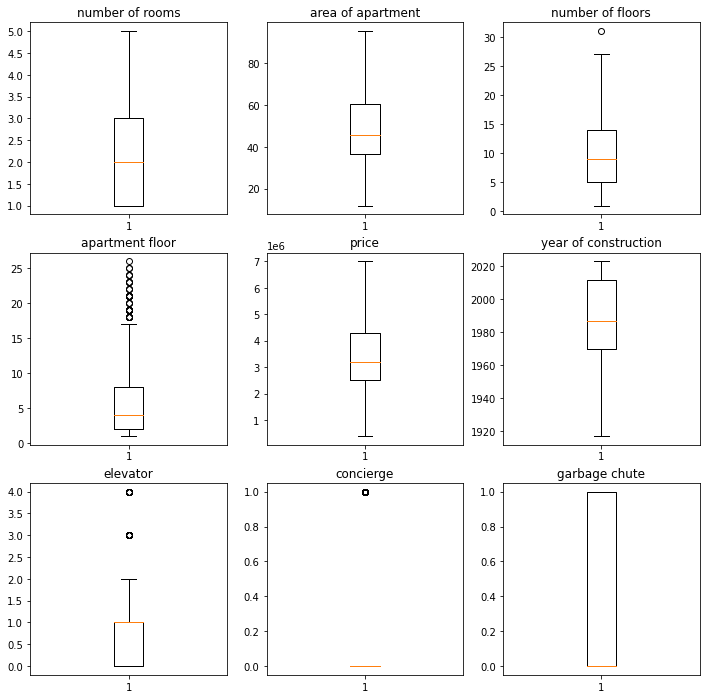

In [290]:
plt.figure(figsize=(12, 12))
for idx, feature in enumerate(numeric_features):
    plt.subplot(3, 3, idx+1)
    plt.boxplot(df[feature])
    plt.title(feature)

Такая ситуация уже лучше, критических выбросов не наблюдается.

## Итоги борьбы с выбросами

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 1893
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number of rooms       1702 non-null   int64  
 1   area of apartment     1702 non-null   float64
 2   number of floors      1702 non-null   int64  
 3   apartment floor       1702 non-null   int64  
 4   price                 1702 non-null   float64
 5   repair                1702 non-null   object 
 6   bathroom              1702 non-null   object 
 7   terrace               1702 non-null   object 
 8   year of construction  1702 non-null   int64  
 9   elevator              1702 non-null   float64
 10  type of house         1702 non-null   object 
 11  parking               1457 non-null   object 
 12  district              1702 non-null   object 
 13  full address          1702 non-null   object 
 14  concierge             1702 non-null   int64  
 15  garbage chute        

In [296]:
df.to_csv('../clean_data_without_outliers.csv', sep=';', index=False)

__В ходе второй обработки были:__
1. выявлены признаки с критическими выбросами
2. удалены выбросы, которые могли оказать негативное влияние на работу нейросети
3. исправлено неправильно введенное значение года постройки